## Loading the Dataset

In [1]:
import yfinance as yf
import pandas as pd

# Loading NVIDIA stock data for the year 2019 and 2024
nvda = yf.download('NVDA', start='2010-01-01', end='2024-12-31')

# Checking the format of the data
print(nvda.info())

# Since the data is in a DataFrame and we observe that there are no missing values, 
# we can proceed to choose the 'Close' price for our analysis.
stock_prices = nvda['Close'].values.reshape(-1, 1)


C:\Users\Harsh Mulodhia\AppData\Local\Temp\ipykernel_1136\1313252932.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda = yf.download('NVDA', start='2010-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3773 entries, 2010-01-04 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, NVDA)   3773 non-null   float64
 1   (High, NVDA)    3773 non-null   float64
 2   (Low, NVDA)     3773 non-null   float64
 3   (Open, NVDA)    3773 non-null   float64
 4   (Volume, NVDA)  3773 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 176.9 KB
None


## Preprocessing the data.

### Scaling the Nvidia Closing Stock Prices using Min-Max Scaling.

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scaling the stock prices to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(stock_prices)

scaled_prices = scaled_prices.reshape(-1, 1)


### Splitting the data into train-test sets for LSTM.

In [3]:
def create_sequences(data, days):
    #Create sequences of stock prices for the given number of days.

    X, y = [], []
    for i in range(len(data) - days):
        X.append(data[i:i + days])
        y.append(data[i + days])
    return np.array(X), np.array(y)


# Assuming the number of days we base our predictions on is 60
days = 60
X, y = create_sequences(scaled_prices, days)

#Splitting the data into train-test sets
training_size = int(len(X) * 0.8)
X_train, X_test = X[:training_size], X[training_size:]
y_train, y_test = y[:training_size], y[training_size:]


## Model Training.

### Fitting the Model.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()
# Adding LSTM layers with dropout for regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=13, batch_size=32)



d:\Harsh Mulodhia\Internship\EL_Projects\Stock Price Trend Prediction\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 2.1868e-04
Epoch 2/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 5.4960e-05
Epoch 3/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 4.1656e-05
Epoch 4/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 4.8541e-05
Epoch 5/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 3.5280e-05
Epoch 6/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 4.8856e-05
Epoch 7/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 5.5022e-05
Epoch 8/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 2.4555e-05
Epoch 9/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 2.9285e-05
Epoch 10/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 3.0842e-05
Epoch 11/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 3.1887e-05
Epoch 12/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 2.6885e-05
Epoch 13/13
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 2.4233e-05


## Model Evaluation and Visualizing the Predictions.

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.2233e-04
Test Loss: 0.0023004268296062946
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


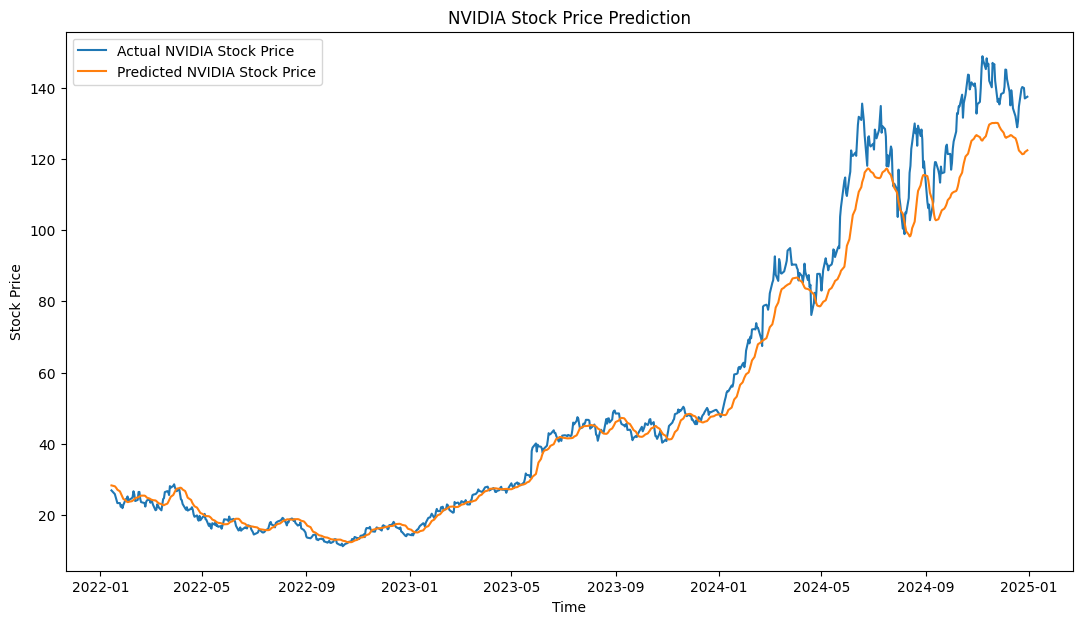

In [5]:
import matplotlib.pyplot as plt

loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

prediction_prices = model.predict(X_test)
prediction_prices = scaler.inverse_transform(prediction_prices)
y_test_price = scaler.inverse_transform(y_test)

test_data_index = nvda.index[-len(y_test):]

plt.figure(figsize=(13, 7))
plt.plot(test_data_index, y_test_price, label='Actual NVIDIA Stock Price')
plt.plot(test_data_index, prediction_prices, label='Predicted NVIDIA Stock Price')
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


## Moving Averages and Relative Strength Index(RSI) Indicators

In [6]:
# Moving Averages
SMA_50 = nvda['Close'].rolling(window=50).mean()
SMA_200 = nvda['Close'].rolling(window=200).mean()

# RSI
def calculate_rsi(data, window=13):
    diff = data['Close'].diff()
    loss = -diff.where(diff < 0, 0)
    gain = diff.where(diff > 0, 0)
    avg_loss = loss.rolling(window=window).mean()
    avg_gain = gain.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

RSI = calculate_rsi(nvda)

### Plotting the moving averages and RSI with the Stock Closing Price and the predicted Stock Closing Price.

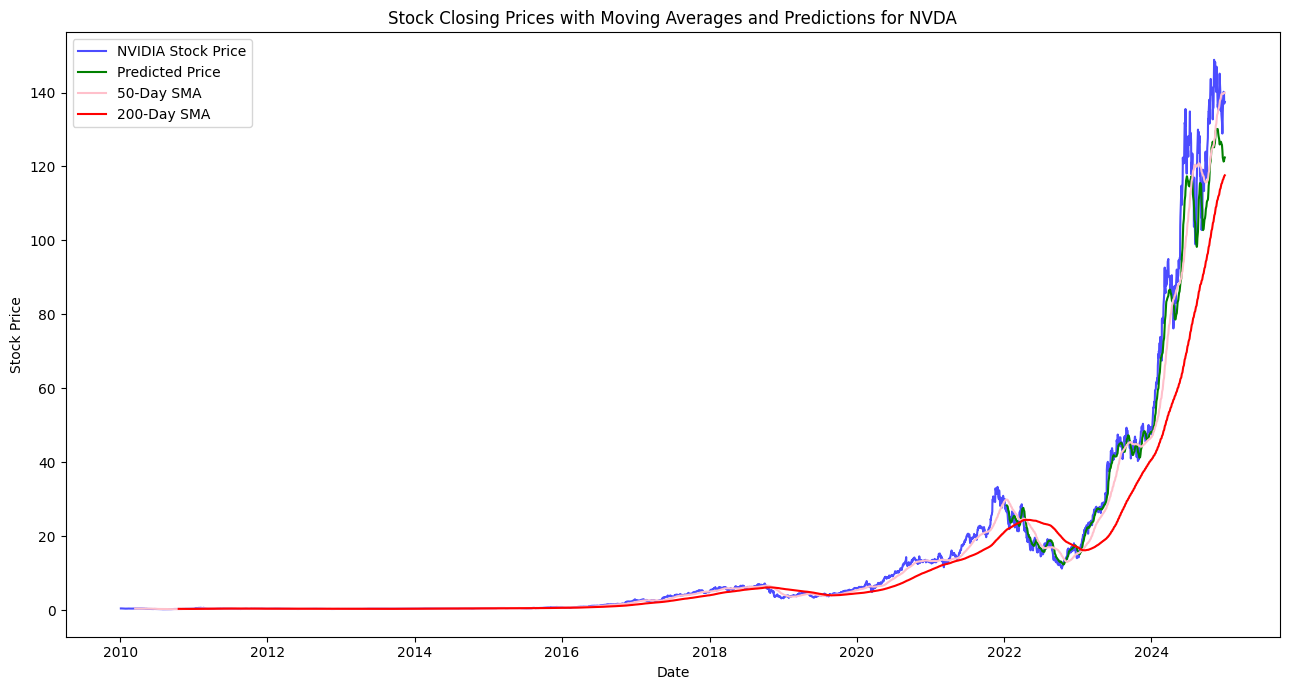

In [7]:
plt.figure(figsize=(13, 7))
plt.plot(nvda.index, nvda['Close'], label='NVIDIA Stock Price', color='blue', alpha=0.7)
plt.plot(test_data_index, prediction_prices, label='Predicted Price', color='green', )
plt.plot(SMA_50.index, SMA_50, label='50-Day SMA', color='pink')
plt.plot(SMA_200.index, SMA_200, label='200-Day SMA', color='red')
plt.title('Stock Closing Prices with Moving Averages and Predictions for NVDA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show()

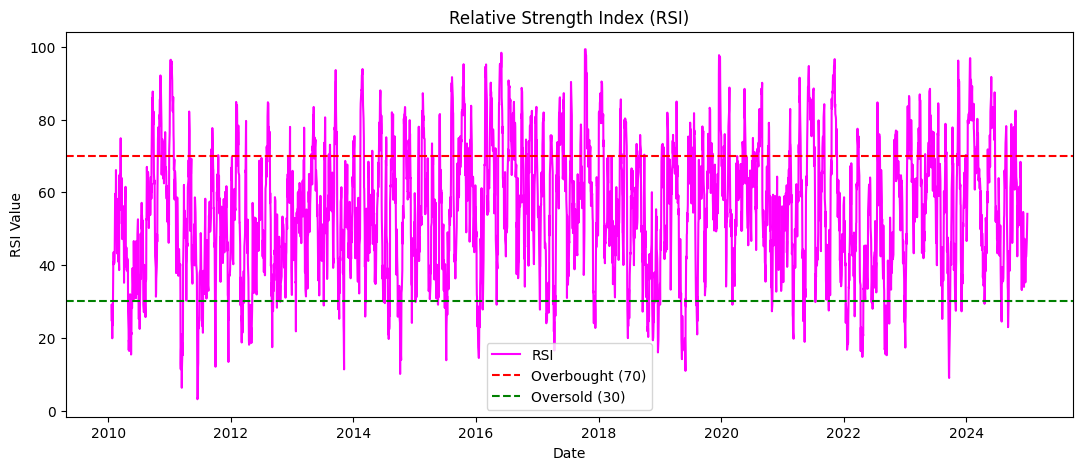

In [8]:
# Plotting the RSI
plt.figure(figsize=(13, 5))
plt.plot(RSI.index, RSI, label = 'RSI', color='magenta')
plt.axhline(70, label = 'Overbought (70)', linestyle='--', color = 'red')
plt.axhline(30, label='Oversold (30)', linestyle='--', color = 'green')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.show()

In [9]:
# Saving the model.
model.save(filepath='LSTM_model.keras')